# Starbucks Capstone Challenge

## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

This Dataset contains three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

## Problem Statement

I aim to answer 2 business questions:
1. To determine the elements that constitute whether a customer will respond to an offer
2. To explore whether a user would take up an offer or are their any common characteristics on the customers who take the offer.

### Importing Libraries & Data

In [2]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### 1. Portfolio Data

#### portfolio.json

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) -
* channels (list of strings)

Offers Terminology used:
1. Bogo - buy one get one free
2. Discount - discount with purchase
3. Informational - provides information about products

In [3]:
# Access the portfolio dataset
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
# check for missing values in dataset
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

Great, no missing values found

In [6]:
# number of unique offers
portfolio.id.nunique()

10

In [7]:
# number of offers by offer type
portfolio.groupby('offer_type').id.count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

### 2. Demographic Data

#### profile.json

* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [8]:
# Access the profile dataset 
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Looks like we have some null values in gender and income columns

In [9]:
#check for null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Looks like we need to take care of some missing values

In [10]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

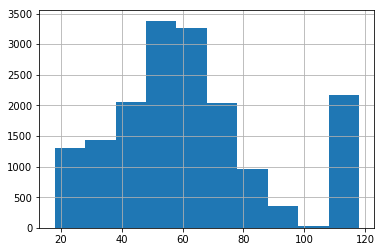

In [11]:
#check distribution of age column
profile.age.hist()

From above we see that, age = 118 value doesn't makes sense as it is out of the normal distribution.

In [12]:
# check for missing values of gender & income for age 118
profile[profile.age==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


So, we can say that age=118 column corresponds to the null gender and income columns. Hence, we can actually drop them during preprocessing if they do not take too large a proportion of our data.

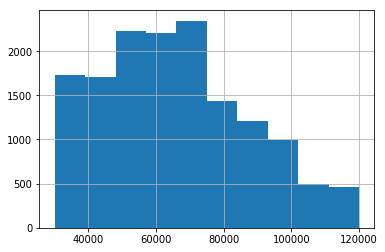

In [13]:
# check for income distribution
profile.income.hist()

### 3. Transactional Data

#### transcript.json

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [14]:
# Access the transcript dataset
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Clearly, we need to extract different values from the value column

In [15]:
# check for missing values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

Great, no missing values found

In [16]:
#check for event distribution
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [17]:
# extracting  different values in value column
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [18]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [19]:
# look at new transcipt dataset
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## Data Preprocessing

To determine the elements that constitute whether a customer will respond to an offer, here firstly we need to process the data to merge the events in each offer sent to a customer in order to find which offer was recieved, viewed and succesfuly completed wih transaction.

In [20]:
#combining 2 datasets(transcript and portfolio)
transcript=transcript.merge(portfolio,how='left',left_on='offer_id',right_on='id')

In [21]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

Since, our data shows that we do not have any offer_id associated with transactions, because they are not recorded in the transcript event data. Hence, in data preprocessing we need to assign offer_ids to specific transactions.

For Bogo and discount offer, both of them will have the consequence of offer received, viewed, transaction and offer completed which will apparently show that the offer is redeemed and should definitely be sent out. For the information offer, though there's no reward step there should still be a transaction which is linked to the usage of the offer.

In [22]:
# when customer do the transaction after receiving and viewing the offer, it should be counted as being 
# responsive to the offer, otherwise either 
# 1) viewing the offer without any transaction or
# 2) making the transaction without receiving or viewing the offer shouldn't be counted as a response


transcript_processed = pd.DataFrame(transcript)

# drop the useless columns
transcript_processed = transcript_processed.drop(columns=['reward_x','reward_y'], axis=1,inplace=False)
transcript_processed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,id,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo


In [23]:
#sort events by person and time
transcript_processed = transcript_processed.sort_values(['person','time'])

After sorting the transcript dataset by person and time to ensure that each event for each person occurs in sequence, We can filter the dataset by events offer viewed and transaction to ensure that it only contains those events in order.

Next, I am using the ffill() method to fill every transaction with the offer_id of the viewed offer, only if it occurs before the transaction.

In [24]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offer_completed = transcript_processed[['time','offer_id','person','event']][(transcript_processed['event']\
    =='transaction') | (transcript_processed['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

In [25]:
# create a complete dataset for filtered data
transcript_processed = transcript_processed.merge(offer_completed, how='left', on=['person','time','event'])
transcript_processed.head()

,event,person,time,value,amount,offer_id_x,channels,difficulty,duration,id,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,3f207df678b143eea3cee63160fa8bed


We should clean up the dataset to unify multiple offer_id columns into one column

In [26]:
# clean up the dataset
transcript_processed['offer_id'] = np.where(transcript_processed['offer_id_x'].isnull(),\
                                            transcript_processed['offer_id_y'], transcript_processed['offer_id_x'])
transcript_processed.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)

In [27]:
transcript_processed.head()

,event,person,time,value,amount,channels,difficulty,duration,id,offer_type,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,3f207df678b143eea3cee63160fa8bed


In [28]:
#merge portfolio dataset again to get offer data for the transaction events
transcript_processed = transcript_processed.merge(portfolio, how = 'left', left_on='offer_id', right_on='id')
transcript_processed['duration'] = np.where(transcript_processed['duration_x'].isnull(), \
                                            transcript_processed['duration_y'], transcript_processed['duration_x'])
transcript_processed.drop(columns=['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],\
                         axis=1, inplace=True)
transcript_processed.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)


In [29]:
# quick check on processed dataset
transcript_processed.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0


In [30]:
# quick check on processed dataset
transcript_processed.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0


We have succesfuly built a more cleaner and accurate dataset

Now, we need to extract the transactions which were completed after the offer was received and viewed. Since we've already filled all transaction's offer id, we can extract the transactions converted from offers by checking if the offer id before the transaction is the same as the transaction's offer id.

In [31]:
# subset the dataset with only offer viewed, transaction, and offer completed events
transactions_after_viewed = transcript_processed[(transcript_processed['event']=='offer viewed')|\
                                                 (transcript_processed['event']=='transaction')|\
                                                 (transcript_processed['event']=='offer completed')].copy()

# generate the previous offer id
transactions_after_viewed['pre_offer_id'] = transactions_after_viewed.groupby(['person', 'offer_id'])['offer_id'].shift()


#flag a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space
transactions_after_viewed['completed_offer'] = np.where(transactions_after_viewed['pre_offer_id']==\
                                                       transactions_after_viewed['offer_id'],1,0)

In [32]:
 # join the 'offer received' events which was filtered out in the previous step
offer_received = transcript_processed[transcript_processed['event']=='offer received']

#ensure all columns are the same between datasets to be appended
offer_received['pre_offer_id']=np.nan
offer_received['completed_offer']=np.nan

#append datasets to complete dataset of transactions
transcript_processed = offer_received.append(transactions_after_viewed).sort_values(['person','time'])
transcript_processed.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,0.0


Since, we consider the conversion events of depending on offer type differently, we have to first separate the transcript into 3 different offer types, in order to accommodate for the different treatment in assigning the target variable.

In [33]:
#define function to split into 3 offer types
def split(offer_type,grp_df):
    '''
    Splits dataframe to groups of specified offer type.
    
    inputs:
    - offer_type: specify offer type name in string format 
    - grp_df: original transcript dataframe to split on offer type
    
    outputs:
    - Returns dataframe containing data of just offer type.
       
    '''
    df=grp_df[grp_df['offer_type']==offer_type].copy()
    return df

#split transcript into 3 different offer types
bogo= split('bogo',transcript_processed)
discount= split('discount',transcript_processed)
informational= split('informational',transcript_processed)

For Bogo and discount offer, the responsed offer should be the one that with 'offer complete' events, and for the informational offer, just 'transaction' can be seen as a successful offer.

In [34]:
# extract responded offer under bogo and informational type
bogo_completed = bogo[['person','offer_id']][(bogo['completed_offer']==1) & (bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_completed = discount[['person','offer_id']][(discount['completed_offer']==1) & (discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()

Next, will seperate out customers who only viewed the offers without transaction and completion in the end, and the customers who only received the offer without viewing it.

In [35]:
# filter out offer with transactions or completed, and offer which have viewed events
bogo_ids_transaction_completed = bogo[['person','offer_id']][(bogo['event']=='transaction') | \
                            (bogo['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
bogo_ids_received = bogo[['person','offer_id']][bogo['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
bogo_merged = bogo_ids_transaction_completed.merge(bogo_ids_received,how='right',on=['person','offer_id'],indicator=True)
bogo_merged.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,both
1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,both
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,both
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,both
4,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,both


In [36]:
# do the same processing on discountrmational offer
discount_ids_transaction_completed = discount[['person','offer_id']][(discount['event']=='transaction') | \
                            (discount['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
discount_ids_received = discount[['person','offer_id']][discount['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
discount_merged = discount_ids_transaction_completed.merge(discount_ids_received,how='right',on=['person','offer_id'],indicator=True)
discount_merged.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,both
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,both
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,both
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,both
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,both


Then, based on merged dataset above, we can seperate out customers who only viewed the offer after they received the offer and customers who didn't even open the offer after they receive the offer.

In [37]:
# subtract the customers who received the offer without finishing the transaction
bogo_no_transaction = bogo_merged[bogo_merged['_merge']=='right_only']
bogo_no_transaction = bogo_no_transaction.merge(transcript_processed, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
bogo_viewed = bogo_no_transaction[['person','offer_id']][bogo_no_transaction['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
bogo_no_transaction.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the BOGO offer 
bogo_no_view = bogo_no_transaction.merge(bogo_viewed[['person','offer_id']], how='left', indicator=True)
bogo_no_view = bogo_no_view[bogo_no_view['_merge']=='left_only'].copy()

In [38]:
# do the same action on discountrmational offer

# subtract the customers who received the offer without finishing the transaction
discount_no_transaction = discount_merged[discount_merged['_merge']=='right_only']
discount_no_transaction = discount_no_transaction.merge(transcript_processed, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
discount_viewed = discount_no_transaction[['person','offer_id']][discount_no_transaction['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
discount_no_transaction.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the discount offer 
discount_no_view = discount_no_transaction.merge(discount_viewed[['person','offer_id']], how='left', indicator=True)
discount_no_view = discount_no_view[discount_no_view['_merge']=='left_only'].copy()

After above processing, filter out the transaction regardless of receiving or viewing the offer.

In [39]:
# subset the offer which has no correction with offer
bogo_unrelated = bogo[['person','offer_id']][(bogo['event']=='offer completed') & (bogo['completed_offer']!=1)]\
                    .groupby(['person','offer_id']).count().reset_index()
discount_unrelated = discount[['person','offer_id']][(discount['event']=='offer completed')\
                    & (discount['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()

After separating the different cases of customers, the following steps will firstly focus on customers who finish the transaction after receiving the offer and customers who only view the offer without any transaction.

In [40]:
# combine the two kind of customers cases which are focused on
bogo_completed['offer_responded']=1
bogo_viewed['offer_responded']=0
bogo_offer = bogo_completed.append(bogo_viewed, sort=False)

discount_completed['offer_responded']=1
discount_viewed['offer_responded']=0
discount_offer = discount_completed.append(discount_viewed, sort=False)

As for the informational offer, the offer could only be counted as responded under the effect of the offer when the transaction is finished within the duration of the offer.

In [41]:
#convert time into days
informational['day_offer']=informational['time']/24
#drop unnecessary columns
informational.drop(['time','value','pre_offer_id'], axis=1, inplace=True)
informational=informational.sort_values(['person','day_offer','event','offer_id'])

#get difference in time for informational offers
informational['diff']=informational[(informational['offer_type']=='informational') \
                                         & ((informational['event']=='offer received')\
                                            | (informational['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()
informational['valid_completion']=np.nan
#flag valid events if within duration
informational.loc[informational['diff']<=informational['duration'],'valid_completion']=1
#fill any missing values with 0 flag
informational['valid_completion']=informational['valid_completion'].fillna(value=0)

In [42]:
informational.head()

,event,person,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,completed_offer,day_offer,diff,valid_completion
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,7.0,NaN,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,0.0,8.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,1.0,9.5,2.5,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,14.0,NaN,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,0.0,15.5,NaN,0.0


From above, when customer make the transaction during the offer effective duration, it can be counted as successfully responsed offer.

In [43]:
#flag successfully responded offer where completed_offer=1 and valid_completion=1
informational['offer_responded']=np.where(((informational['completed_offer']==1)\
                                           & (informational['valid_completion']==1)),1,0)

In [44]:
# extract the informational offer successfully compelted after
info_completed = informational[['person','offer_id']][informational['offer_responded']==1]\
                        .groupby(['person','offer_id']).sum().reset_index()

In [45]:
# filter out offer with transactions or completed, and offer which have viewed events
informational_ids_transaction_completed = informational[['person','offer_id']][(informational['event']=='transaction') | \
                            (informational['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
informational_ids_received = informational[['person','offer_id']][informational['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
informational_merged = informational_ids_transaction_completed.merge(informational_ids_received,how='right',on=['person','offer_id'],indicator=True)

In [46]:
# subtract the customers who received the offer without finishing the transaction
informational_no_transaction = informational_merged[informational_merged['_merge']=='right_only']
informational_no_transaction = informational_no_transaction.merge(transcript_processed, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
informational_viewed = informational_no_transaction[['person','offer_id']][informational_no_transaction['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
informational_no_transaction.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the informational offer 
informational_no_view = informational_no_transaction.merge(informational_viewed[['person','offer_id']], how='left', indicator=True)
informational_no_view = informational_no_view[informational_no_view['_merge']=='left_only'].copy()

In [47]:
# append the informational offer together
info_completed['offer_responded']=1
informational_viewed['offer_responded']=0
informational_offer = info_completed.append(informational_viewed, sort=False)

## Feature Engineering

Now we have to look back had to look into the features and see how to be creative in creating new features.

 ###  Column to know about length of customer's membership

There could be some influence in how long someone has been a member, with whether he takes up an offer.

In [48]:
#rename column for merging
profile.rename(columns={'id':'person'},inplace=True)

#create function to generate the length of time since the user become the member
def member_since(df):
    '''
    inputs:
    - df: dataframe to generate the ength of time since the user become the member
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = df.drop('became_member_on', axis=1, inplace=False)
    df.loc[df['year'] == 2018, 'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df = df.drop(['year','month','day'], axis=1, inplace=False)
    
    return df

bogo_offer=member_since(bogo_offer)
discount_offer=member_since(discount_offer)
informational_offer=member_since(informational_offer)

### Count of the number of offers recieved

As part of some further data exploration, I found that there could be multiple offers received per person.

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


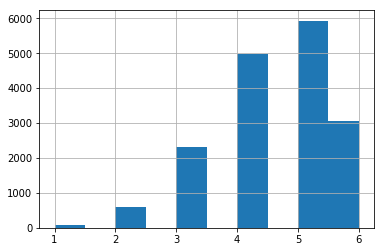

In [49]:
#group event=offer received per person in transactional records
print(transcript_processed[transcript_processed['event']=='offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
transcript_processed[transcript_processed['event']=='offer received'].groupby('person')['event'].count().hist()

In [50]:
# generate the count of offers received per person
offer_cnt=transcript_processed[transcript_processed['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()
offer_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

offer_cnt.drop(['time'], axis=1, inplace=True)

# ensure only unique person-offer_id pairs
offer_cnt=offer_cnt.groupby(['person','offer_id']).sum().reset_index()
offer_cnt.head()

,person,offer_id,offer_received_cnt
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


### Seperate user behaviour by transactions

To subtract the transactions which's not related to the offer

In [51]:
# subtract the transactions which's not related to the offer
transactions_not_related=transcript_processed[(transcript_processed['event']=='transaction') & (transcript_processed['completed_offer']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
transactions_not_related.rename(columns={'amount':'amount_invalid'},inplace=True)

### Time elapsed between offers recieved

To include time as a potential feature, but since the transactional data starts from time=0, I suspected it would not have been of much predictive power without some feature engineering. I had the hypothesis that if there were multiple offers received per person within a certain time period, there might be some predictive power in the time elapsed between offers received.

In [52]:
# convert time into days
transcript_processed['day_offer']=transcript_processed['time']/24
# drop unnecessary columns
transcript_processed.drop(['time'], axis=1, inplace=True)

# calculate the time between offers
transcript_processed['time_gap']=transcript_processed[transcript_processed['event']=='offer received'].groupby(['person','offer_id'])['day_offer'].diff()

# fill missing values with 0
transcript_processed['time_gap']=transcript_processed['time_gap'].fillna(value=0)

df_time_gap=transcript_processed.groupby(['person','offer_id'])['time_gap'].sum().reset_index()

## Data Prepration

By recalling our initial preliminary data exploration, there are some steps to prepare the data:

###  Merging temporary datasets created above to include engineered features

In [53]:
# merge to get offers received count and invalid amount transacted 
bogo_offer=bogo_offer.merge(offer_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
bogo_offer=bogo_offer.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

###  Drop missing values in gender column for demographic data

In [54]:
#check % of missing values in dataset
(bogo_offer.isnull().sum()/len(bogo_offer)*100).sort_values(ascending=False).head()

amount_invalid        96.323752
income                 7.057489
gender                 7.057489
offer_received_cnt     0.000000
membership_days        0.000000
dtype: float64

We can see that the missing values are quite extensive especially for the amount_invalid column, I decided to fill the missing amount_invalid column with 0 as it could represent that only 3% of the overall users tend to purchase without offers; the other 97% would only purchase with awareness of an ongoing offer.

In [55]:
# fill missing values for amount_invalid with 0
bogo_offer['amount_invalid']=bogo_offer['amount_invalid'].fillna(value=0)
bogo_offer.dropna(inplace=True)


### Separate the channel column into categorical variables

In [56]:
# Split the channel column into categorical variables
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

# dummy variable encoding function
def dummy(df,col):
    df = pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df = df.drop([col], axis=1, inplace=False)
    return df

portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [57]:
# merge with portfolio to get offer details
bogo_offer=bogo_offer.merge(portfolio,how='left',on='offer_id')

# convert channels into categorical variables
channels = bogo_offer['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
bogo_offer = pd.concat([bogo_offer[:], channels[:]], axis=1)
rename('web',bogo_offer)
rename('email',bogo_offer)
rename('mobile',bogo_offer)
rename('social',bogo_offer)
bogo_offer = bogo_offer.drop(['channels'], axis=1, inplace=False)

# convert gender into categorical variables
bogo_offer=dummy(bogo_offer,'gender')

Similarly, doing the same for the discount data

In [58]:
# merge to get offers received count and invalid amount transacted 
discount_offer = discount_offer.merge(offer_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
discount_offer = discount_offer.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

In [59]:
# fill missing values for amount_invalid with 0
discount_offer['amount_invalid']=discount_offer['amount_invalid'].fillna(value=0)
discount_offer.dropna(inplace=True)

In [60]:
# merge with portfolio to get offer details
discount_offer= discount_offer.merge(portfolio,how='left',on='offer_id')

# convert channels into categorical variables
channels = discount_offer['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
discount_offer = pd.concat([discount_offer[:], channels[:]], axis=1)
rename('web',discount_offer)
rename('email',discount_offer)
rename('mobile',discount_offer)
rename('social',discount_offer)
discount_offer = discount_offer.drop(['channels'], axis=1, inplace=False)

#convert gender into categorical variables
discount_offer=dummy(discount_offer,'gender')

Now, for processing on informational data

In [61]:
# merge with portfolio to get offer details
informational_offer = informational_offer.merge(portfolio,how='left',on='offer_id')

# reset index for informational_offer
informational_offer = informational_offer.reset_index().drop(['index'],axis=1,inplace=False)

# split the channel column
informational_offer['email']= np.nan
informational_offer.loc[pd.Series(['email' in informational_offer['channels'][x] for x in range(len(informational_offer['channels']))]),'email']=1
informational_offer['email']=informational_offer['email'].fillna(value=0)

informational_offer['mobile']= np.nan
informational_offer.loc[pd.Series(['mobile' in informational_offer['channels'][x] for x in range(len(informational_offer['channels']))]),'mobile']=1
informational_offer['mobile']=informational_offer['mobile'].fillna(value=0)

informational_offer['social']= np.nan
informational_offer.loc[pd.Series(['social' in informational_offer['channels'][x] for x in range(len(informational_offer['channels']))]),'social']=1
informational_offer['social']=informational_offer['social'].fillna(value=0)

In [62]:
# drop the useless columns
informational_offer.drop(['channels'], axis=1, inplace=True)

In [63]:
# merge the informational offer dataframe
informational_offer = informational_offer.merge(offer_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
informational_offer = informational_offer.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

In [64]:
# fill missing values for amount_invalid and offer_received_cnt with 0
informational_offer['amount_invalid']=informational_offer['amount_invalid'].fillna(value=0)

#drop income and gender null rows
informational_offer.dropna(inplace=True);    

#convert gender column into dummy variables
informational_offer=dummy(informational_offer,'gender')

In [65]:
# Access informational_offer data
informational_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,difficulty,duration,offer_type,reward,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,3,informational,0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,0.0,1.0,0.00,1,0,0


## Model Implementation

Now that the datasets are ready, we can proceed to implementing the model.

I decided to compare the performance of a simple decision tree classifier model as a baseline model, with an ensemble random forest classifier model. Reason why I selected a decision tree as the baseline model is because I wanted to prioritise the interpretability of the model. Going back to the objective, since we intend to analyse the feature importance to determine the drivers of an effective offer, a decision tree would provide good interpretability for us to analyse.

Meanwhile, I also selected random forest as an alternate model to compare the baseline model is as an improvement over simple ensemble bagging of decision trees, also to drive towards a high accuracy in training the model.

### Model Metrics

As, the classes for the all 3 models are imbalanced, I decided to implement both accuracy and f1 score as the model evaluation metric. F1 score provides a better sense of model performance compared to purely accuracy as takes both false positives and false negatives in the calculation. With an uneven class distribution, F1 may usually be more useful than accuracy.

Since,  F1 score is based on the harmonic mean of precision and recall, and focuses on positive cases. For the Starbucks app here, it would be fine as we would prioritise more on whether offers are effective, and less focus on why offers are ineffective.

### Model Preparation

We have to create 3 models to predict the effectiveness of an offer within each type, depending on offer attributes and user demographics.

Firstly, we have to define our target and features variables.

In [66]:
def data_prep(df,drop_cols_prep):
    '''
    inputs:
    - df: prepared dataframe for modeling 
    
    outputs:
    - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['offer_responded']
    features = df.drop(drop_cols_prep, axis=1, inplace=False)
    return features,target

Spliting data into training and test sets

In [67]:
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

Now, we have to implement 3 different models for different offer types. Hence, it would be easier to implement repeatedly

In [68]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the model to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the model to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [69]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results from models
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

#### 1. Bogo model

We initialize the models with some randomly chosen parameters to check the initial performance. If performance needs to be improved further

In [70]:
# implement the model for BOGO offer
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(bogo_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1670
MSE_test: 0.1786
Training accuracy:0.8330
Test accuracy:0.8214
             precision    recall  f1-score   support

          0     0.4906    0.0594    0.1059       438
          1     0.8287    0.9866    0.9008      2020

avg / total     0.7684    0.8214    0.7591      2458



From above, we can see that accuracy for Random Forest Classifier model ends up outperforming the Decision Tree Classifier model slightly, but overall the performance for both models is about the same (82.14% vs 81.77% respectively in terms of accuracy). Accuracy for a first attempt is quite good, more than 80%. I will try to tune the model further to get a better accuracy.

But the F1 score is a bit lower than accuracy which may be tuned better in the later steps. From the result we can see that Decision Tree's F1 performs a little better than Random Forest, which means that decision tree is doing slightly better compared to random forest at not misclassifying negative events as positive (meaning, misclassifying people on which offers are ineffective, as people on which offers would be effective).

#### 2. Discount Model

In [71]:
# instantiate the model for discount offer
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(discount_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1313
MSE_test: 0.1277
Training accuracy:0.8687
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0062    0.0122       325
          1     0.8729    0.9991    0.9317      2220

avg / total     0.8253    0.8723    0.8143      2545



Again, the Random Forest Classifier model also has a better performance compared to the Decision Tree Classifier in terms of accuracy (87.23% vs 86.72%), and the F1 score is also lower (81.43% vs 82.87%)

But, F1 score for these models are lower overall compared to the Accuracy score. As stated earlier,  it's more important in this business case for the model predicting positive cases accurately.
So, random forest classifier model has better performance.

#### 3. Informational Model

In [72]:
# implement model for informational offer
features,target=data_prep(informational_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2319
MSE_test: 0.2520
Training accuracy:0.7681
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5200    0.1099    0.1814       355
          1     0.7610    0.9655    0.8511      1042

avg / total     0.6997    0.7480    0.6809      1397



The performance for this model is worse compared to the other 2 models, with accuracy below 80% for both models, but RF model still performing better. The F1 score is also worse, at 67.54% RF Classifier, worse than the DT model at 68.66%. We might have missed out on some valuable information by removing those transactions(that only occur after an offer is viewed and within the specified duration) that occur regardless.

### Model Refining

Here, we will attempt to tune the parameters of initial model using GridSearch method to get higher performance. We will try parameter tuning for all 3 models

Since, we will be comparing the models based on testing score repeatedly, I built a function to find the best RF model results based on refinement depending on offer type.

In [73]:
# creating a function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print(offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

For all three offers, the Random Forest model had relatively good performance, so I used Grid Search on this to determine the best parameters.

In [74]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15],
                'n_estimators': [10,20,25,30],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10,15],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [75]:
#define BOGO dataset
features,target=data_prep(bogo_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 20}

So, we have the optimal parameters for the Bogo model, we run our model again with the new parameters, keeping the DecisionTree baseline model with the same parameters as comparison.

In [76]:
# use optimized parameters to rerun the model in previous step
# initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1613
MSE_test: 0.1717
Training accuracy:0.8387
Test accuracy:0.8283
             precision    recall  f1-score   support

          0     0.5870    0.1233    0.2038       438
          1     0.8377    0.9812    0.9038      2020

avg / total     0.7930    0.8283    0.7790      2458



In [77]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.029464,0.031144
testing_score,0.821400,0.828316
train_time,0.148669,0.154307
training_score,0.833045,0.838742


In [78]:
# best model for BOGO offer type
best_model('bogo')

bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.031144,0.828316,0.154307,0.838742


We see that accuracy for the RF model increased slightly - from 82.14% to 82.51%, and the F1 score increased from 75.91% to 77.64%. It is a good performance increase but minimal, which indicates that perhaps there's not much that can be done to improve the performance of the model with parameter tuning.

In [79]:
# do the same tuning and refit steps on discount offer
features,target=data_prep(discount_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 30}

So, we have the optimal parameters for the discount model, we run our model again with the new parameters, keeping the DecisionTree baseline model with the same parameters as comparison.

In [80]:
# initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=30,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1350
MSE_test: 0.1261
Training accuracy:0.8650
Test accuracy:0.8739
             precision    recall  f1-score   support

          0     1.0000    0.0123    0.0243       325
          1     0.8737    1.0000    0.9326      2220

avg / total     0.8898    0.8739    0.8166      2545



In [81]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.041421,0.045705
testing_score,0.872299,0.873870
train_time,0.166120,0.234019
training_score,0.868749,0.865016


In [82]:
# best model for discount offer type
best_model('discount')

discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.045705,0.87387,0.234019,0.865016


As shown above in the comparison, after using tune parameters, the test accuracy slightly improved from 0.872 to 0.873 and the F1 score increase from 0.814 to 0.816.

In [83]:
# refining for informational offer model
features,target=data_prep(informational_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 10}

So, we have the optimal parameters for the informational model, we run our model again with the new parameters, keeping the DecisionTree baseline model with the same parameters as comparison.

In [84]:
# rerun the model with selected paramenters
info_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=10,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2378
MSE_test: 0.2470
Training accuracy:0.7622
Test accuracy:0.7530
             precision    recall  f1-score   support

          0     0.5893    0.0930    0.1606       355
          1     0.7599    0.9779    0.8552      1042

avg / total     0.7165    0.7530    0.6787      1397



In [85]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.019665,0.009537
testing_score,0.748031,0.753042
train_time,0.099726,0.048448
training_score,0.768129,0.762220


In [86]:
# best model for informational offer type
best_model('info')

info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.009537,0.753042,0.048448,0.76222


Again we see some improvement in accuracy for RF model, from 75.09% to 75.30%, and slight increase in F1 score from 67.54% to 67.78%. This improvement is minimal,so we look into improving the feature selection of the model.

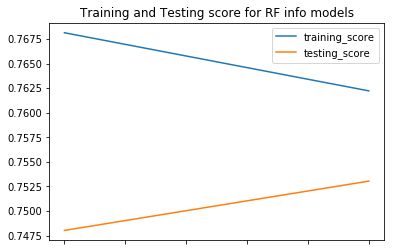

In [87]:
results.loc[['training_score','testing_score'],['RandomForestClassifier_info_1','RandomForestClassifier_info_2']].transpose().plot.line()
plt.title('Training and Testing score for RF info models')
plt.show()

## Best Features

A look at our 3 models result and to know the insights of elements that constitute to whether a customer will respond to offer or not.

In [88]:
# quick look at our 3 models
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

bogo RF model:
discount RF model:
info RF model:


,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_2,RandomForestClassifier_info_2
pred_time,0.031144,0.045705,0.009537
testing_score,0.828316,0.873870,0.753042
train_time,0.154307,0.234019,0.048448
training_score,0.838742,0.865016,0.762220


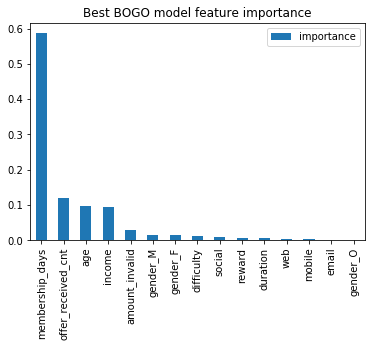

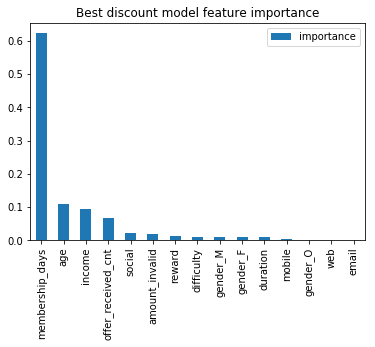

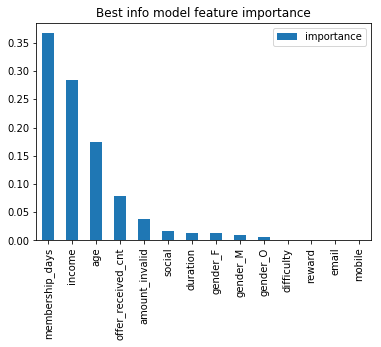

In [94]:
# BOGO model
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(bogo_offer,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount model
feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#informational model
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(informational_offer,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()


## Conclusion

With that, we come to the end of this challenging project. We aimed to answer the 2 business questions:
    
1. To determine the elements that constitute whether a customer will respond to an offer
2. To explore whether a user would take up an offer or are their any common characteristics on the customers who take the offer.

Let's see the reflection of our findings through the project for these questions.

#### Question 1:

Here I found that, the feature importance given by three models shows that the length of the membership is the most important factor which affect how customer will make reponse to the offer.

We saw that for all the models the top 3 variables were all same that included:
1. Membership tenure
2. Income
3. Age

But, Income and age switched the orders depending upon the offer type.
Also, we saw that Bogo and Discount offers, the distribution of feature importances were relatively equal. For Bogo offer, the count of offer received is the second important factor which decide if the customer will make the transaction.However, for informational offers the distribution is slightly more balanced than other two, with income the next more important variable.


#### Question 2:

The decision to use 3 separate models to predict the effectiveness of each offer type ended up with good accuracy for the Bogo and discount models (82.83% for Bogo and 87.35% for discount), while slightly less accurate performance for informational offers (75.3%). However, I would regard 75% as acceptable in a business setting, as for informational offers, there is no cost involved to inform users of a product.

Although, the model performance of informational offer is slightly lower but is still acceptable in this phase of research. And for Bogo and discount models, the cost won't be too much to send out the offer even some people doesn't repond to it and it should be fine with this level of model performance

### Main Challenges and Improvement

The main scope of improvement can be that the analysis is focused more on customer's who successfully finish the transaction after they received the offer, there should be more insight for the other cases where the customer finishes the transactions regardless of the offer. If we could get any insight into those cases, maybe we can send out more offers to those customers. 

I would have liked to have more data to perhaps understand why this group of customers tend to not be influenced by offer, in order to make useful suggestions on how to give a good customer experience to these customers, even if we do not serve them any offers.

Also, I can do some more experiment on feature engineering step to see if any other new features can improve the model, also I could also try to reduce some feature to see how it will affect the model performance.